# Visualizing Backpropagation

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Emmanuel Rachelson and Dennis G. Wilson | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

The ANN, value propagation (forward pass), and error backpropagation (backward pass), code from the main notebook are all available in `ann.py`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ann

We'll use this code to visualize value propagation and error backpropagation during training using the same neural network architecture as seen in class.

<img src="img/nn3.png" width="600px"></img>

In [2]:
sizes = [2,4,3,1]
myann = ann.ANN(sizes)

To visualize the network, we'll use the `networkx` package.

In [3]:
ids = np.append([0], np.cumsum(sizes))
id_layers = []
G = nx.Graph()
for l in range(1, len(ids)):
    id_layers.append([i for i in range(ids[l-1], ids[l])])
for l in range(len(id_layers)):
    for i in id_layers[l]:
        G.add_node(i, subset=l)
for l in range(1, len(id_layers)):
    for i in id_layers[l-1]:
        for j in id_layers[l]:
            G.add_edge(i, j)

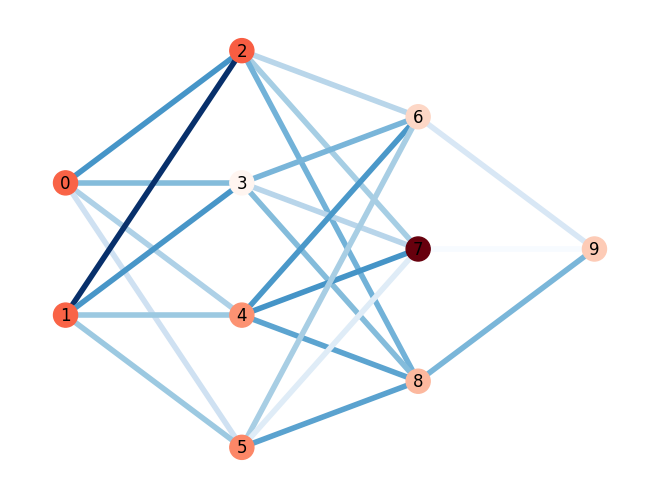

In [4]:
weights = [i for l in myann.weights for i in l.flatten()]
biases = np.concatenate((np.zeros(sizes[0]),
                         [i for l in myann.biases for i in l.flatten()]))
first_weights = np.copy(weights)
first_biases = np.copy(biases)
options = {
    "width": 4,
    "cmap": plt.cm.Reds,
    "edge_cmap": plt.cm.Blues,
    "with_labels": True,
}
pos = nx.multipartite_layout(G)            
nx.draw(G, pos, **options, edge_color=weights, node_color=biases)

As before, we'll train the network to approximate the function $x_0,x_1\mapsto \sqrt{x_0+x_1}$

In [5]:
import numpy as np
# generate training and testing sets
def func(x):
    return np.sqrt(x[:,0]+x[:,1])

testing_x  = np.random.uniform(size=(100,2))
testing_y  = func(testing_x).reshape(-1,1)
training_x = np.random.uniform(size=(100,2))
training_y = func(training_x).reshape(-1,1)

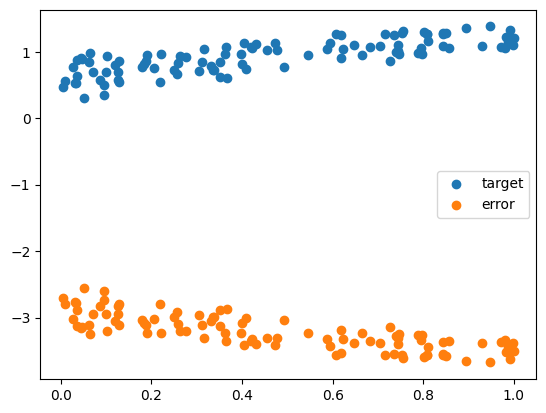

In [6]:
y, s, z = myann.forward_pass(training_x, verbose=False)
out = training_y
error = z[-1] - out
plt.scatter(training_x[:, 0], training_y, label='target')
plt.scatter(training_x[:, 0], error, label='error')
plt.legend();

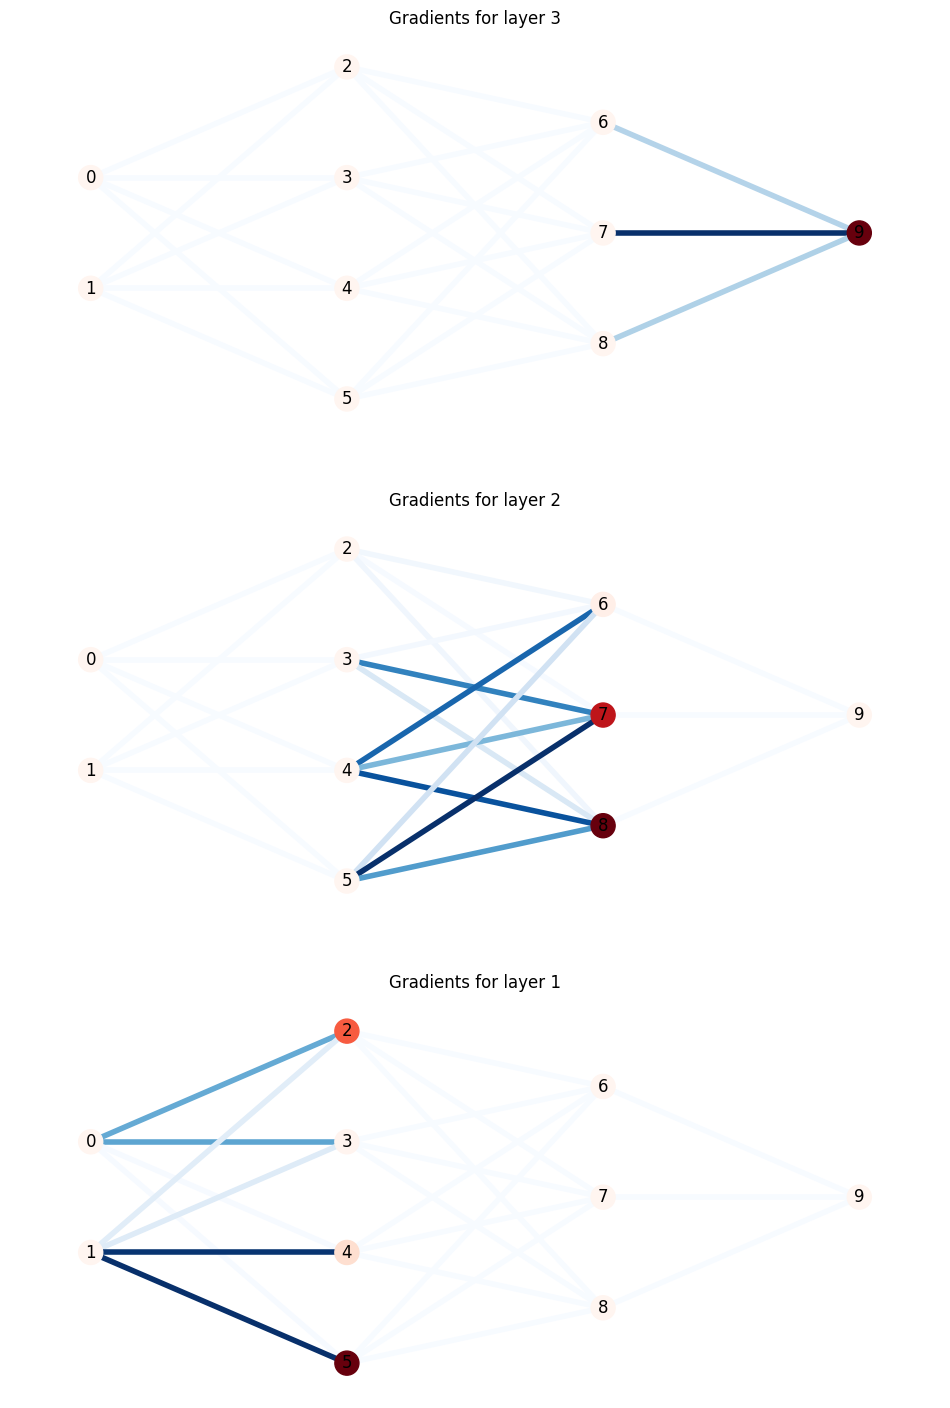

In [7]:
plt.figure(figsize=(12, 24))
# initialize gradient vectors for each layer
delta = [np.zeros((out.shape[0], sz)) for sz in myann.layer_sizes]
grad_w = [np.zeros((o, i)) for i, o in
      zip(myann.layer_sizes[:-1], myann.layer_sizes[1:])]
grad_b = [np.zeros((1, y)) for y in myann.layer_sizes[1:]]
#learning rate
alpha = 0.01
for i in range(len(myann.layer_sizes)-1, 0, -1):
    if i == len(myann.layer_sizes)-1:
        delta[i] = s[-1]
    else:
        delta[i] = np.dot(delta[i+1], myann.weights[i])
        delta[i] = np.multiply(delta[i], s[i])
    # delta at each layer
    delta_temp = np.multiply(delta[i], error)
    # reset weight gradients to 0 for plotting
    grad_w = [np.zeros((o, i)) for i, o in
          zip(myann.layer_sizes[:-1], myann.layer_sizes[1:])]
    # gradient of weights at this layer
    grad_w[i-1] = np.dot(delta_temp.T, z[i-1])
    # reset bias gradients to 0 for plotting
    grad_b = [np.zeros((1, y)) for y in myann.layer_sizes[1:]]
    # gradients of biases at this layer
    grad_b[i-1] = np.sum(delta_temp, axis=0)
    # flatten weight and bias gradients for plotting
    dw_flat = [np.abs(i) for l in grad_w for i in l.flatten()]
    db_flat = np.concatenate((np.zeros(sizes[0]),
                              [np.abs(i) for l in grad_b for i in l.flatten()]))
    # plot
    plt.subplot(len(myann.layer_sizes), 1, len(myann.layer_sizes)-i)
    plt.title("Gradients for layer "+str(i))
    nx.draw(G, pos, **options, edge_color=dw_flat, node_color=db_flat)
    # IMPORTANT: update weights for next step of backprop
    myann.weights[i-1] -= alpha * grad_w[i-1]
    myann.biases[i-1] -= alpha * grad_b[i-1]

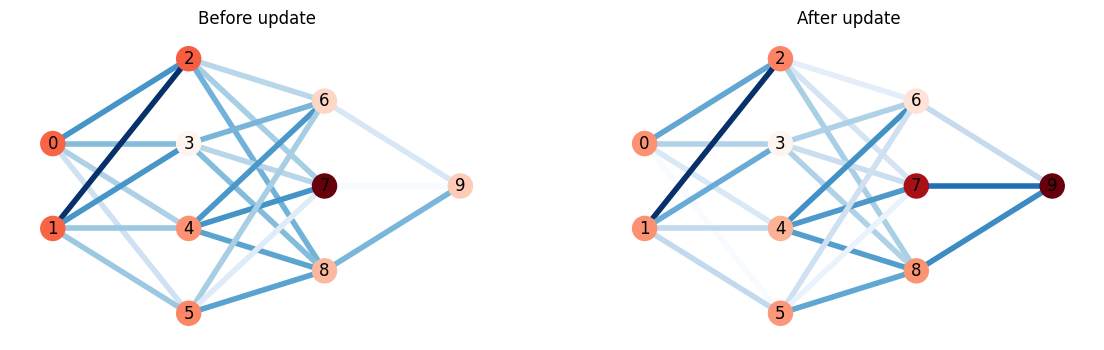

In [8]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title("Before update")
nx.draw(G, pos, **options, edge_color=first_weights, node_color=first_biases)
weights = [i for l in myann.weights for i in l.flatten()]
biases = np.concatenate((np.zeros(sizes[0]),
                         [i for l in myann.biases for i in l.flatten()]))
plt.subplot(1, 2, 2)
plt.title("After update")
nx.draw(G, pos, **options, edge_color=weights, node_color=biases)

In [9]:
# compute initial generalization loss
y,s,z = myann.forward_pass(testing_x, verbose=False)
err = np.mean((z[-1]-testing_y)**2)
print("Generalization loss estimate:",err)

Generalization loss estimate: 10.767577664386764


This is one backwards step. For training, we'll use the definition of `backward_pass` in the `ANN` class.

In [10]:
# myann.reset_weights()
nsteps = 1000
training_loss = np.zeros(nsteps)
testing_loss  = np.zeros(nsteps)

for i in range(nsteps):
    _,_,z_test = myann.forward_pass(testing_x, verbose=False)
    testing_loss[i]  = np.mean((z_test[-1]-testing_y)**2)
    y_train,s_train,z_train = myann.forward_pass(training_x, verbose=False)
    training_loss[i] = np.mean((z_train[-1]-training_y)**2)
    myann.backward_pass(training_y, y_train, s_train, z_train, 0.001)

last training loss: 0.0583844220184114
last generalization loss: 0.050699469292290314


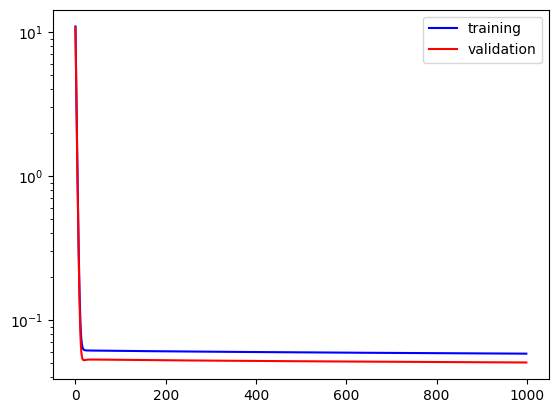

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.semilogy(training_loss, c='b', label='training')
plt.semilogy(testing_loss, c='r', label='validation')
plt.legend()
print("last training loss:", training_loss[-1])
print("last generalization loss:", testing_loss[-1])